### <span style="color:teal"> __UNIPARTITE - TAXA NETWORK ANALYSIS__ 

<span style="color:teal"> In a taxa‐centric unipartite species network, microbial genera are represented as nodes, and an edge is drawn between two genera when they co‐occur in association with one or more diseases in the underlying dataset. This projection is derived from an underlying disease–species bipartite network, where diseases act as the intermediate nodes linking microbial taxa. Such a network highlights patterns of co‐association between different genera, revealing microbial groups that tend to be enriched, depleted, or otherwise altered together across disease contexts. By focusing on taxa–taxa connections, it becomes possible to identify potential ecological relationships, such as mutualistic or competitive interactions, as well as core dysbiosis modules that appear in multiple diseases. This perspective shifts the emphasis from individual disease contexts to the broader microbial community structure, offering a systems‐level view of microbial interactions within the host and their potential roles in health and disease.

In [12]:
# LOADING REQUIRED PACKAGES
import pickle
from collections import Counter
import itertools
import json
import powerlaw
from kneed import KneeLocator
import pickle

# NetworkX and Seaborn
from networkx.algorithms import bipartite
import seaborn as sns
from collections import defaultdict

# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

import matplotlib.ticker as ticker 

from adjustText import adjust_text
import networkx as nx
from networkx.algorithms import bipartite
import community as community_louvain  # Louvain community detection (python-louvain)
import textwrap
# Optional: Configure matplotlib to use a specific style or suppress warnings
# plt.style.use('seaborn-whitegrid')  # optional, if you want a consistent style

In [13]:
# LOADING THE UNIPARTITE DISEASE _species PROJECTION NETWORK
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/network_analysis/bipartite_genus_network.gpickle", "rb") as f:
    B_genus = pickle.load(f)

In [14]:
# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_dict.json", "r") as f:
    taxon_dict = json.load(f)

# Load the phenotype mapping JSON
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/taxon_phyla_dict.json", "r") as f:
    taxon_category_by_id = json.load(f)


=== Network Summary ===
Number of nodes: 375
Number of edges: 23415
Degree range: (15.0, 319.0)
Edge weight range: (1.0, 18.0)


/tmp/slurm.4393939/ipykernel_3819428/63969163.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


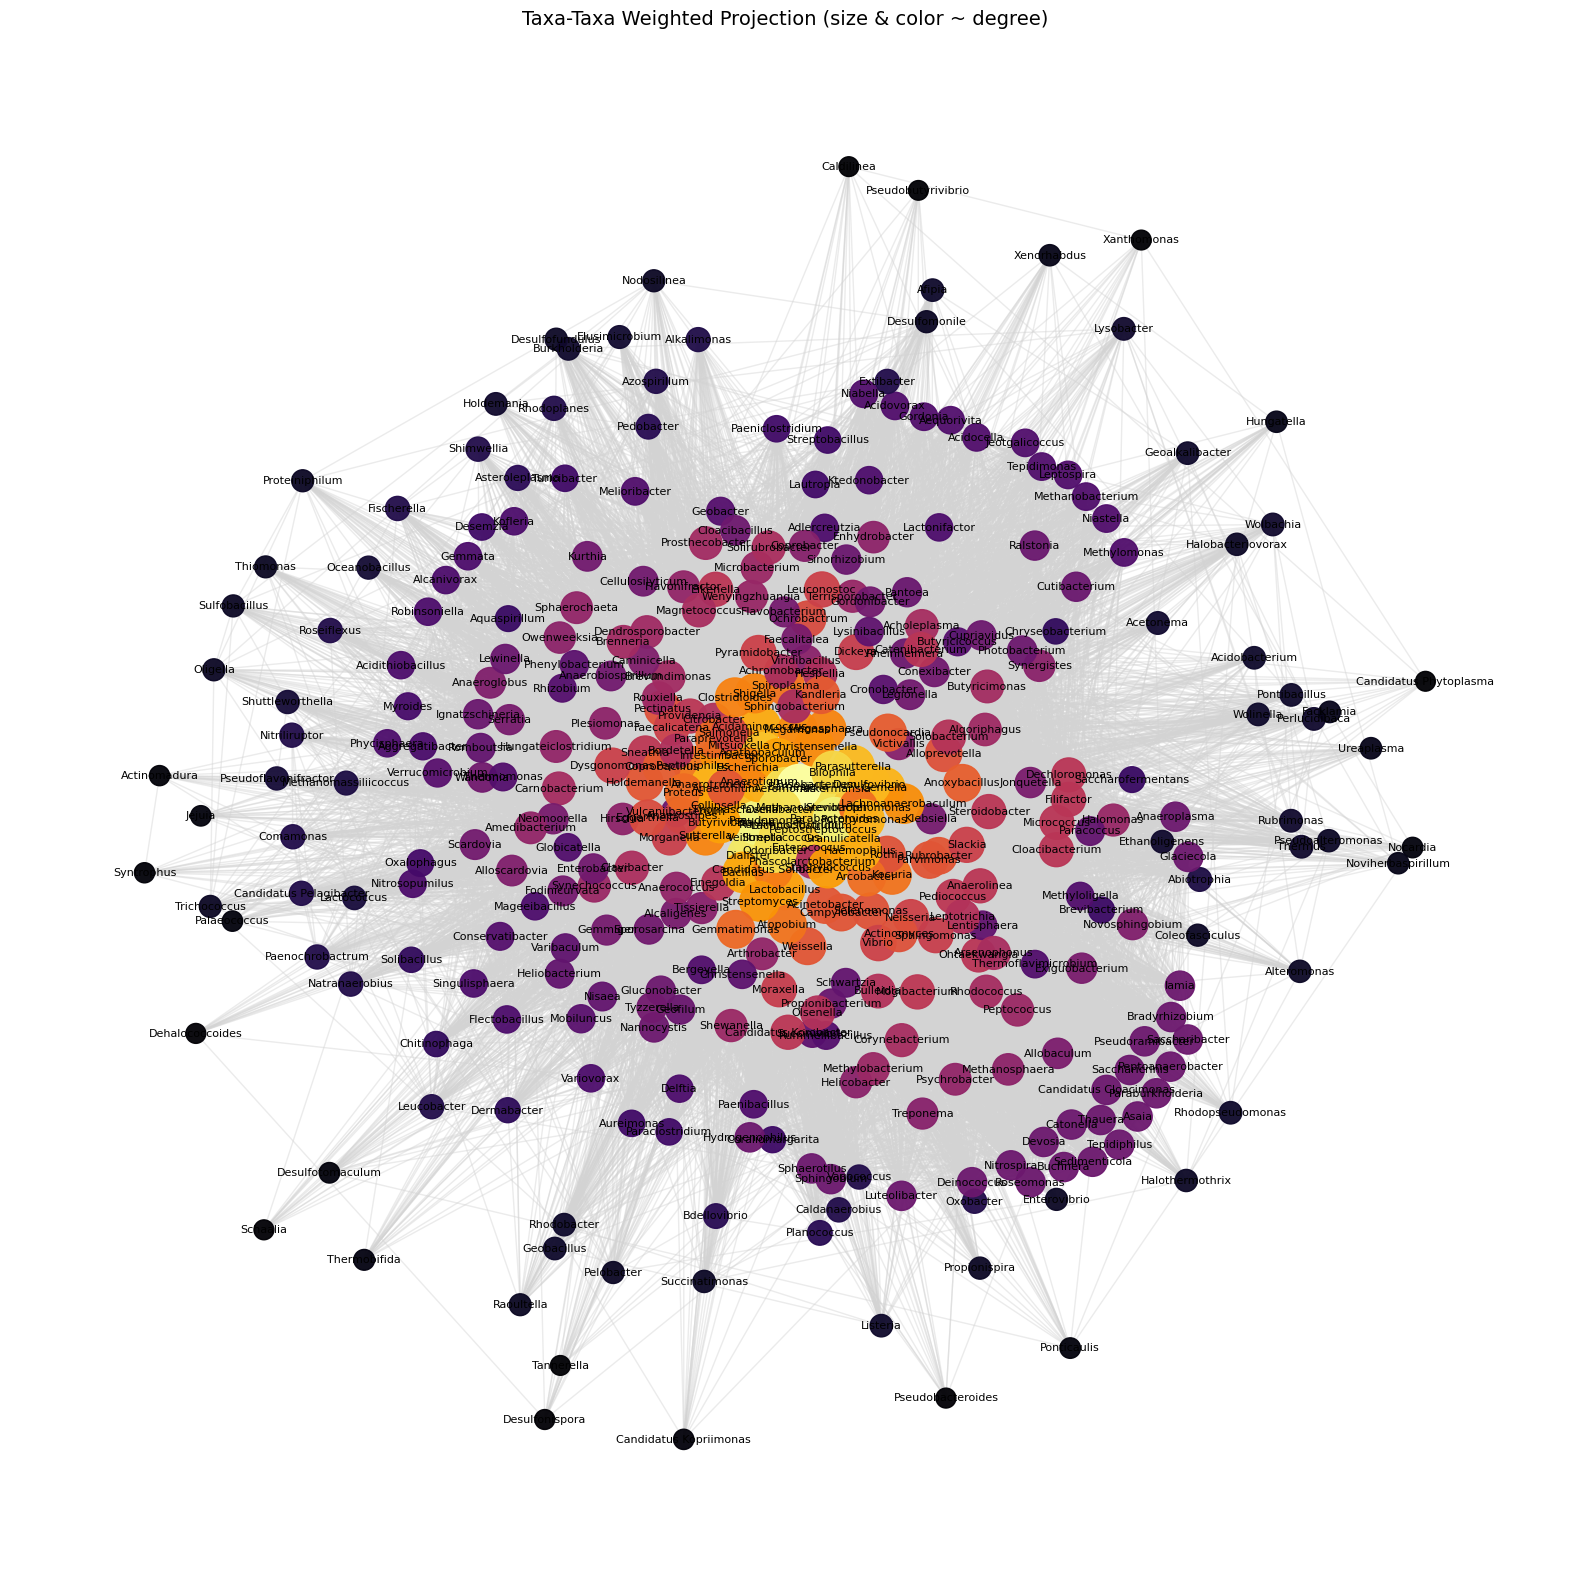

In [15]:
# BIPARTITE DISEASE DIEASE NETWORK
# --- Partitions from B_genus (assumes bipartite attr: 0=diseases, 1=taxa) ---
taxa = {n for n, d in B_genus.nodes(data=True) if d.get("bipartite") == 1}
if not taxa:
    raise ValueError("No taxa nodes found with bipartite==1 in B_genus.")

# --- Weighted unipartite projection: disease–disease (weight = shared taxa count) ---
G = bipartite.weighted_projected_graph(B_genus, taxa)

# === Summary stats ===
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
deg_vals = np.array([deg for _, deg in G.degree()], dtype=float)
weights = np.array([d.get("weight", 1.0) for _, _, d in G.edges(data=True)], dtype=float)

summary = {
    "Number of nodes": num_nodes,
    "Number of edges": num_edges,
    "Degree range": (deg_vals.min() if deg_vals.size else None,
                     deg_vals.max() if deg_vals.size else None),
    "Edge weight range": (weights.min() if weights.size else None,
                          weights.max() if weights.size else None)
}
print("=== Network Summary ===")
for k, v in summary.items():
    if isinstance(v, tuple):
        v = tuple(float(x) if x is not None else None for x in v)
    print(f"{k}: {v}")

# --- Layout ---
pos = nx.spring_layout(G, seed=42, k=1.2)

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Node colors: same normalization → Inferno colormap ---
cmap = cm.get_cmap("inferno")
node_colors = cmap(deg_norm)  # RGBA colors aligned with node order below

# --- Edge widths: normalize weights to [0,1] then map to pixel range ---
if weights.size:
    wmin, wmax = weights.min(), weights.max()
    w_norm = (weights - wmin) / (wmax - wmin) if wmax != wmin else np.ones_like(weights)
    edge_widths = 1.0 + 4.0 * w_norm
else:
    edge_widths = []

# --- Labels from disease_dict (fallback to code if missing) ---
labels = {n: taxon_dict.get(n, str(n)) for n in G.nodes()}

# --- Draw ---
plt.figure(figsize=(20, 20))

# Edges first
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.45, edge_color="lightgray")

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(G.nodes()),
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.95,
)

# Labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Taxa-Taxa Weighted Projection (size & color ~ degree)", fontsize=14)
plt.axis("off")
plt.show()


Calculating best minimal value for power law fit
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


=== Network Summary (Filtered) ===
Number of nodes: 106
Number of edges: 1592
Density: 0.2861
Average degree: 30.04
Maximum degree: 81 (node: 1508657)
Power-law alpha: 2.82
Power-law xmin: 25.0


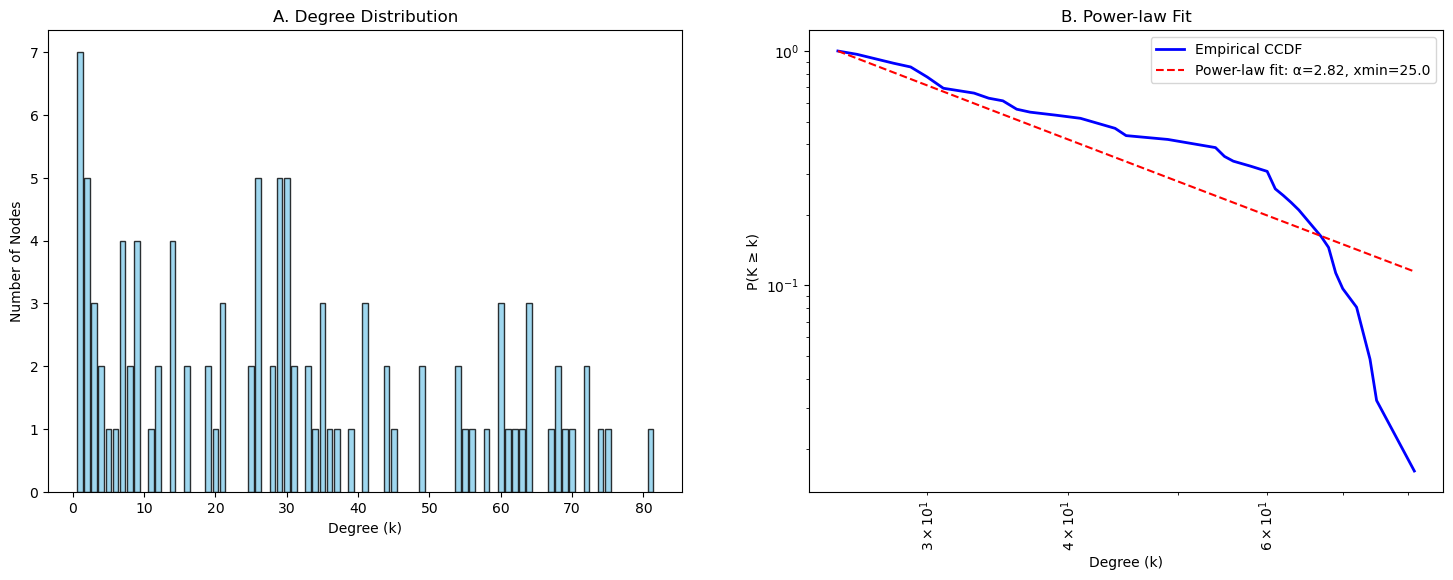

In [16]:
# === User-defined threshold ===
edge_weight_threshold = 5 # change this to your cutoff

# === Step 1: Apply edge weight filtering ===
if edge_weight_threshold > 0:
    G_filtered = nx.Graph()
    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 1)  # default weight = 1 if not present
        if weight >= edge_weight_threshold:
            G_filtered.add_edge(u, v, **data)
else:
    G_filtered = G.copy()

# === Step 2: Degree histogram data ===
degrees = [deg for _, deg in G_filtered.degree()]
unique_deg, counts = np.unique(degrees, return_counts=True)

# === Step 3: Power-law fit for CCDF ===
fit = powerlaw.Fit(degrees, discrete=True)
alpha = fit.alpha
xmin = fit.xmin

# === Step 4: Network layout ===
pos = nx.spring_layout(G_filtered, seed=42, k=2)  # change layout if needed

# === Step 5: Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Panel A: Degree histogram
axes[0].bar(unique_deg, counts, color='skyblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel("Degree (k)")
axes[0].set_ylabel("Number of Nodes")
axes[0].set_title("A. Degree Distribution")

# Panel B: CCDF with power-law fit
# Plot CCDF
fit.plot_ccdf(ax=axes[1], color='blue', linewidth=2, label='Empirical CCDF')
fit.power_law.plot_ccdf(ax=axes[1], color='red', linestyle='--',
                        label=f'Power-law fit: α={alpha:.2f}, xmin={xmin}')

# Force normal numbers on x-axis
#axes[1].set_xscale('linear')
axes[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1].ticklabel_format(style='plain', axis='x')
axes[1].tick_params(axis='x', which='both', labelrotation=90) 

# ✅ Add axis labels
axes[1].set_xlabel("Degree (k)")
axes[1].set_ylabel("P(K ≥ k)")  # CCDF definition

axes[1].legend()
axes[1].set_title("B. Power-law Fit")

# === Step 0: Basic network statistics ===
num_nodes = G_filtered.number_of_nodes()
num_edges = G_filtered.number_of_edges()
density = nx.density(G_filtered)
avg_degree = sum(dict(G_filtered.degree()).values()) / num_nodes if num_nodes > 0 else 0
max_degree_node, max_degree = max(G_filtered.degree(), key=lambda x: x[1]) if num_nodes > 0 else (None, 0)

print("=== Network Summary (Filtered) ===")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density:.4f}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Maximum degree: {max_degree} (node: {max_degree_node})")
print(f"Power-law alpha: {alpha:.2f}")
print(f"Power-law xmin: {xmin}")


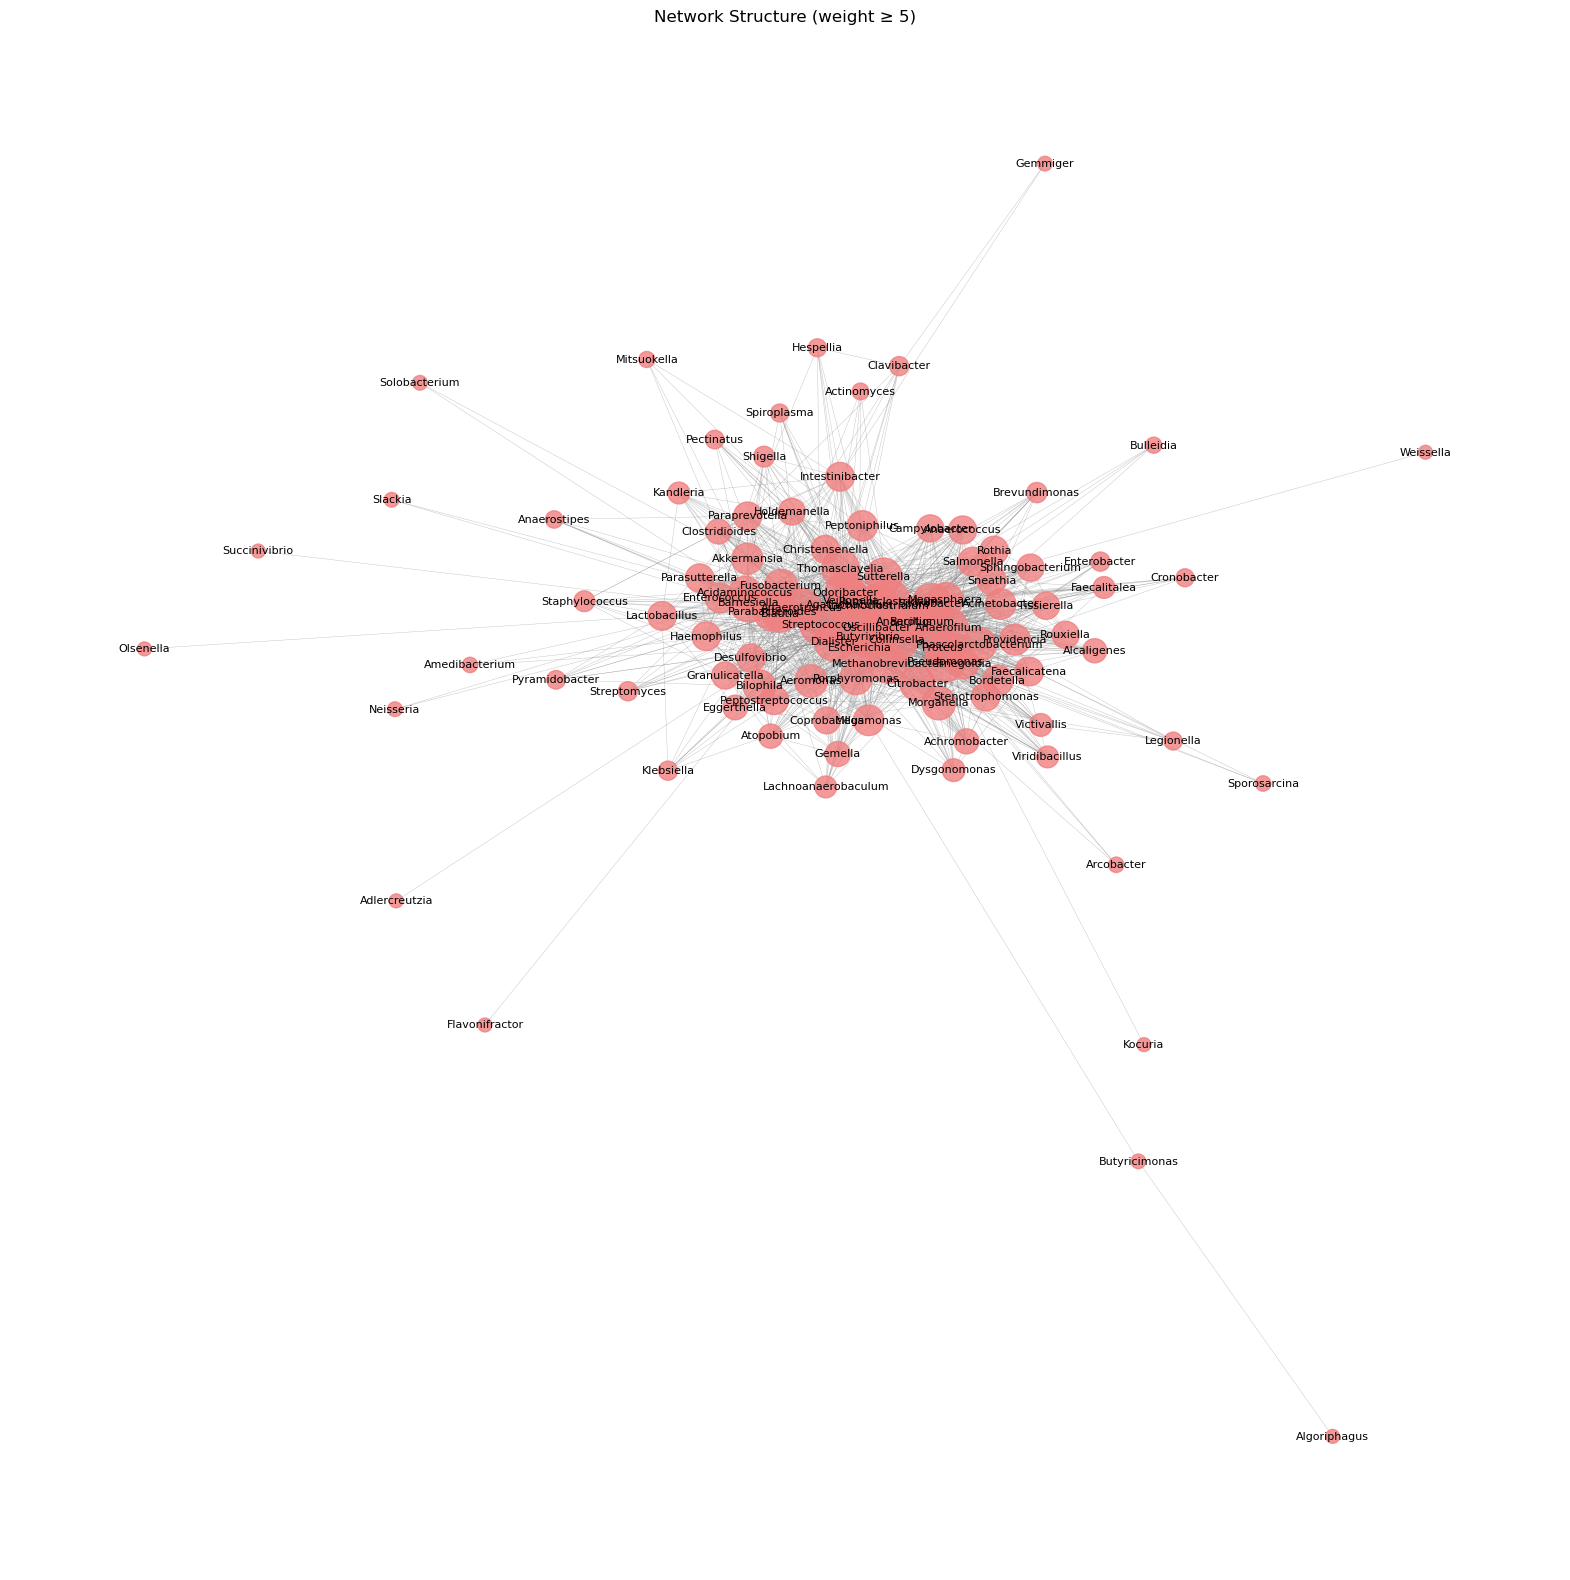

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# If you don't already have pos from a previous cell, compute it here:
pos = nx.spring_layout(G_filtered, seed=42)

# Map node IDs to readable labels from taxon_dict
labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node sizes: normalize degree to [0,1] then map to pixel range ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)

min_size, max_size = 100, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Plot ---
plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.8)
nx.draw_networkx_edges(G_filtered, pos, width=0.3, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8)

plt.title(f"Network Structure (weight ≥ {edge_weight_threshold})")
plt.axis('off')
plt.show()


/tmp/slurm.4393939/ipykernel_3819428/2262940826.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(used_categories), 1))
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


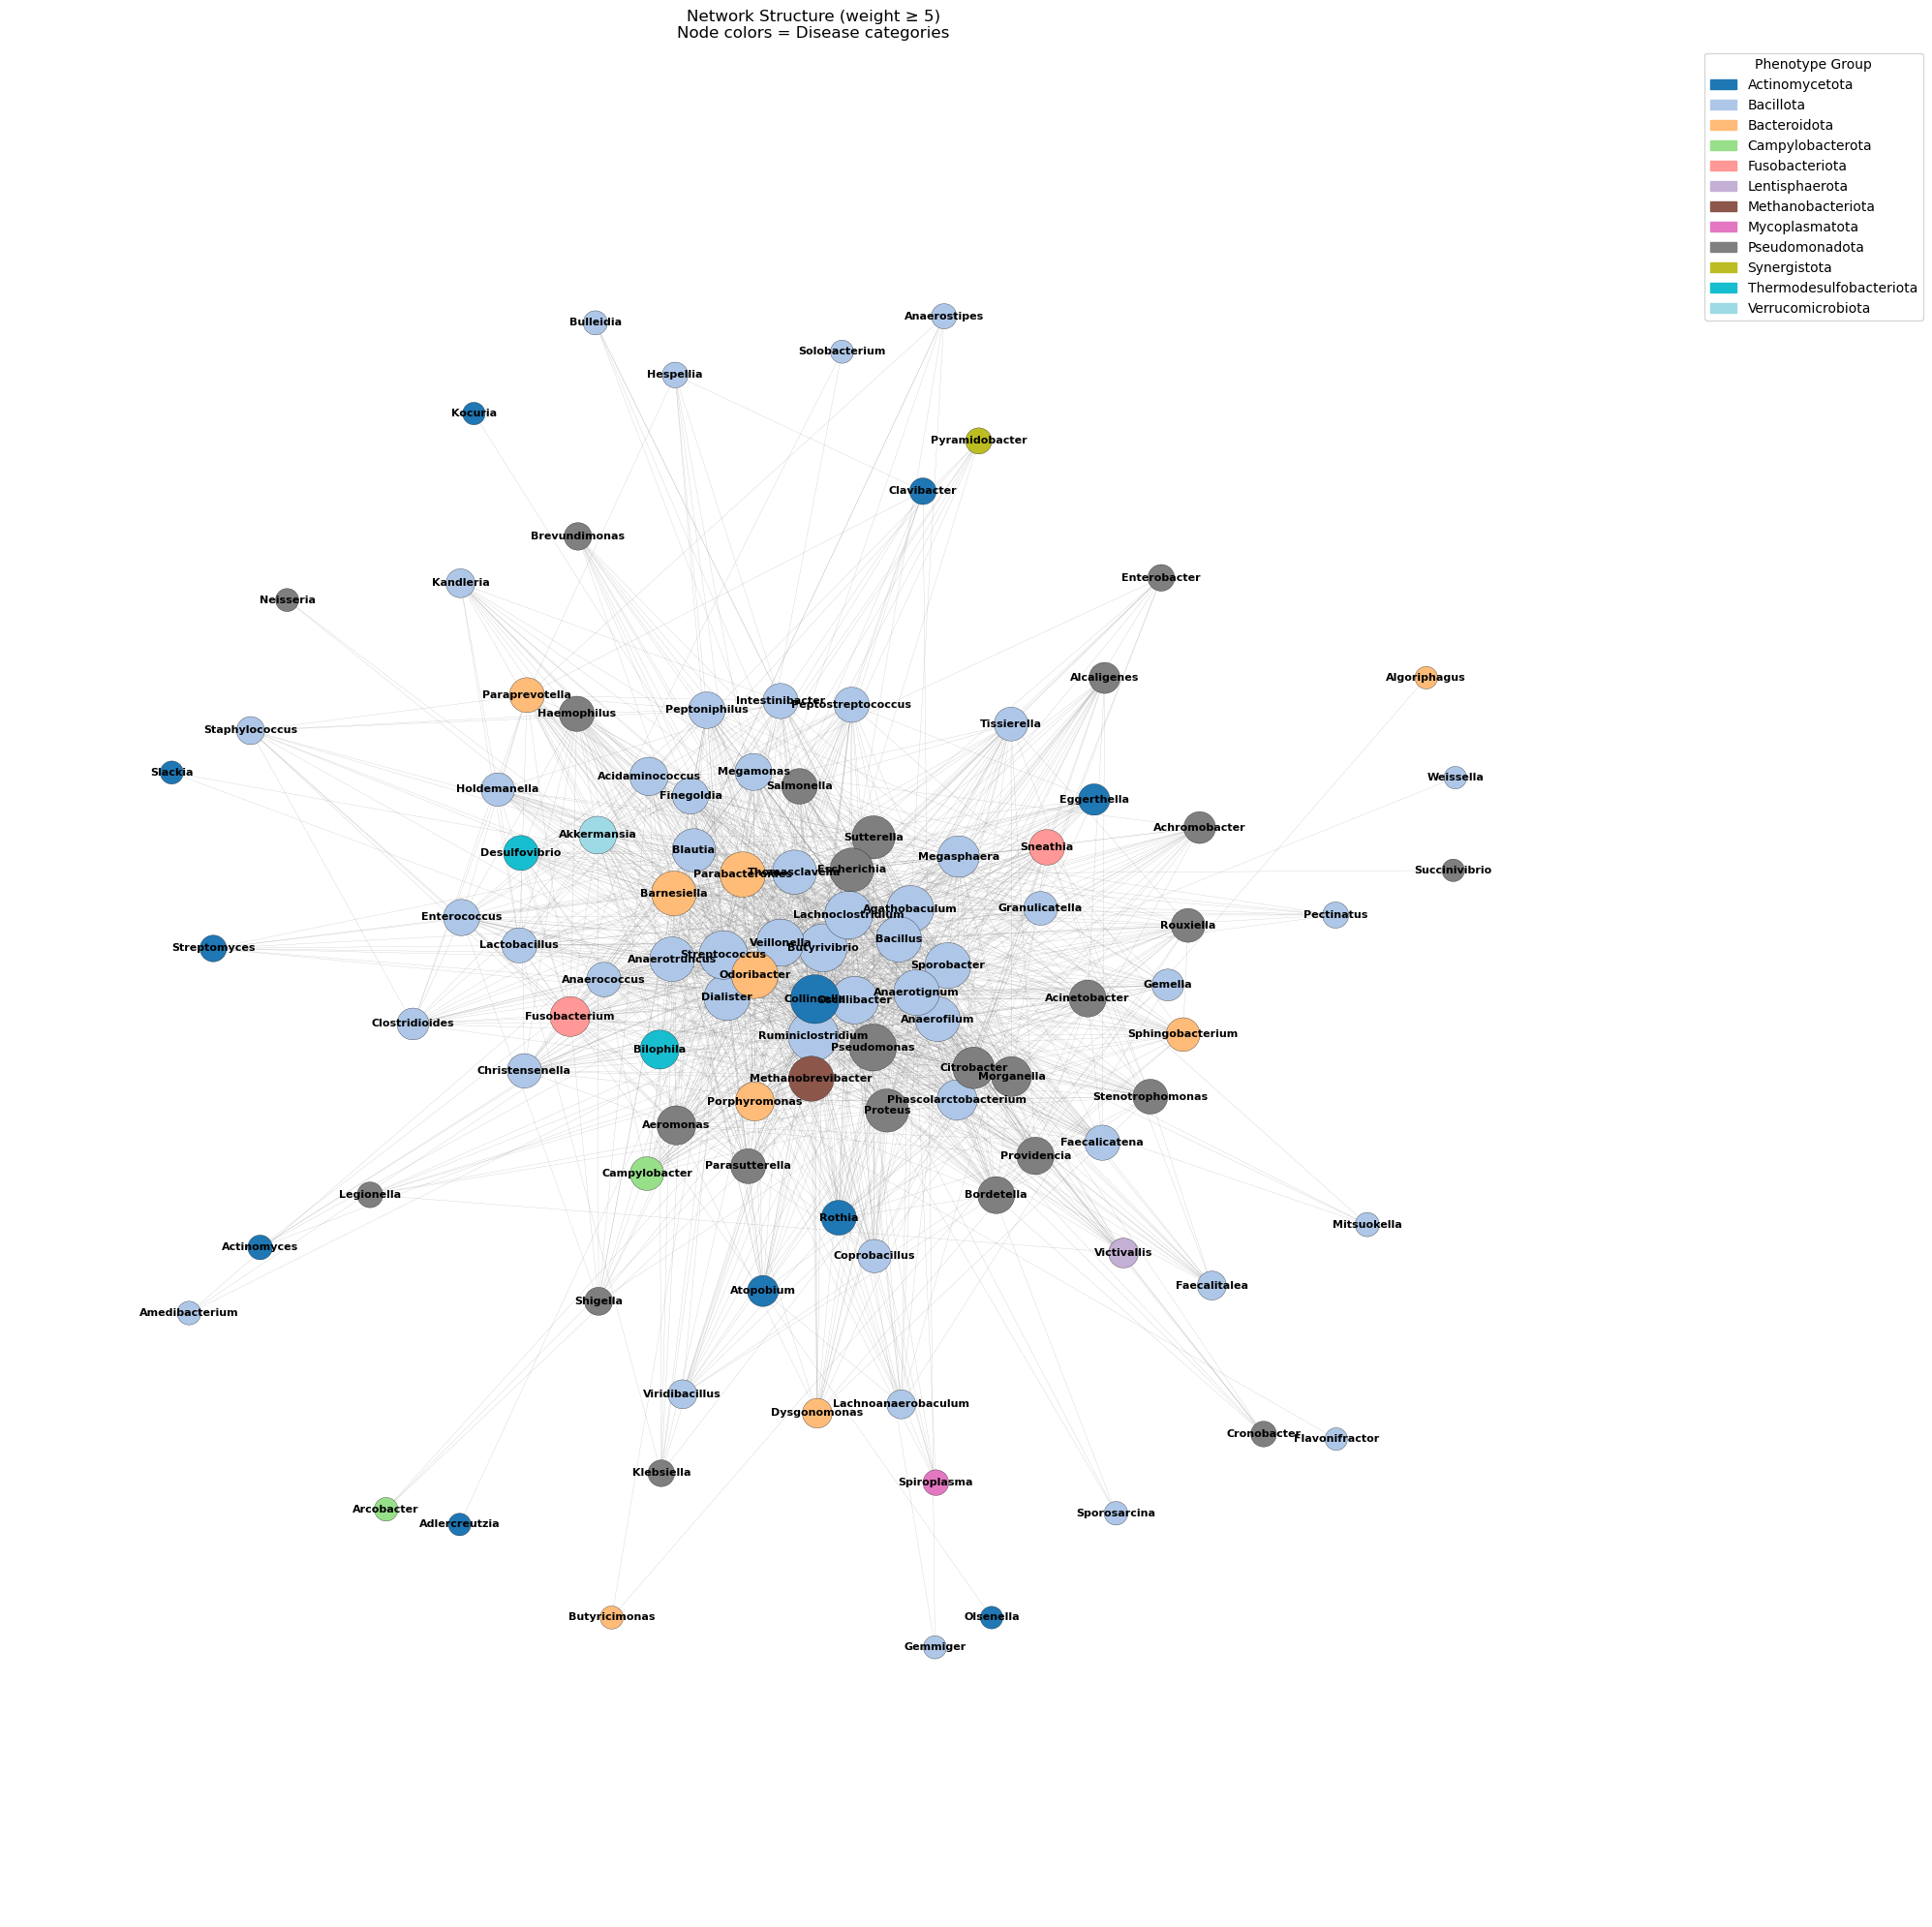

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np

# Ensure all node IDs are strings to match dictionary keys
G_filtered = nx.relabel_nodes(G_filtered, {n: str(n) for n in G_filtered.nodes()})
taxon_category_by_id = {str(k): ([str(c) for c in v] if isinstance(v, list) else [str(v)])
                        for k, v in taxon_category_by_id.items()}

# --- Layout & labels ---
pos = nx.spring_layout(G_filtered, seed=42, k=2)

# Scale the layout outward without recalculating
scale_factor = 4.0
pos = {n: (x * scale_factor, y * scale_factor) for n, (x, y) in pos.items()}

labels = {n: taxon_dict.get(n, str(n)) for n in G_filtered.nodes()}

# --- Node size from degree ---
deg_vals = np.array([deg for _, deg in G_filtered.degree()], dtype=float)
if deg_vals.size == 0:
    raise ValueError("Graph has no nodes.")
dmin, dmax = deg_vals.min(), deg_vals.max()
deg_norm = (deg_vals - dmin) / (dmax - dmin) if dmax != dmin else np.ones_like(deg_vals)
min_size, max_size = 200, 1000
node_sizes = min_size + deg_norm * (max_size - min_size)

# --- Normalize categories per node ---
node_cats = {}
for n in G_filtered.nodes():
    cats = taxon_category_by_id.get(n, [])
    if not cats or not isinstance(cats, list):
        cats = ["(Unclassified)"]
    cats = [str(c).strip() if c else "(Unclassified)" for c in cats]
    node_cats[n] = cats

# --- Used categories ---
used_categories = sorted({c for cats in node_cats.values() for c in cats})

# --- Color map for categories ---
cmap = plt.cm.get_cmap("tab20", max(len(used_categories), 1))
category_colors = {cat: cmap(i) for i, cat in enumerate(used_categories)}

# --- Figure & axis ---
fig, ax = plt.subplots(figsize=(20, 20))

# Draw edges
nx.draw_networkx_edges(G_filtered, pos, width=0.2, alpha=0.5, ax=ax, edge_color="gray")

# Axis limits from positions
xs = np.array([p[0] for p in pos.values()])
ys = np.array([p[1] for p in pos.values()])
pad_x = (xs.max() - xs.min()) * 0.10
pad_y = (ys.max() - ys.min()) * 0.10
ax.set_xlim(xs.min() - pad_x, xs.max() + pad_x)
ax.set_ylim(ys.min() - pad_y, ys.max() + pad_y)
ax.set_aspect('equal', adjustable='datalim')

# Convert node size to radius in data coords
def points2data_radius(ax, size_pts2):
    r_pts = np.sqrt(size_pts2 / np.pi)          # points
    r_px = r_pts * (fig.dpi / 72.0)             # pixels
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    dx_per_px = (x1 - x0) / ax.bbox.width
    dy_per_px = (y1 - y0) / ax.bbox.height
    return r_px * 0.5 * (dx_per_px + dy_per_px)

# Draw nodes as pie slices
for size, n in zip(node_sizes, G_filtered.nodes()):
    cats = node_cats[n]
    r = points2data_radius(ax, size)
    x, y = pos[n]
    k = len(cats)
    for j, cat in enumerate(cats):
        theta1 = 360.0 * j / k
        theta2 = 360.0 * (j + 1) / k
        wedge = mpatches.Wedge(
            (x, y), r, theta1, theta2,
            facecolor=category_colors.get(cat, "lightgray"),
            edgecolor="black", lw=0.2, zorder=2
        )
        ax.add_patch(wedge)

# Labels
nx.draw_networkx_labels(G_filtered, pos, labels=labels, font_size=8, ax=ax, font_weight='bold')

# Title
ax.set_title(f"Network Structure (weight ≥ {edge_weight_threshold})\nNode colors = Disease categories")
ax.axis('off')

# Legend
legend_handles = [mpatches.Patch(color=category_colors[c], label=c) for c in used_categories]
ax.legend(handles=legend_handles, title="Phenotype Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
import networkx as nx
import pandas as pd
import community as community_louvain  # Louvain community detection

# --- Helper: Get name from disease_dict if available ---
def get_name(node):
    return taxon_dict.get(node, str(node))

# --- Centrality Measures ---
metrics = {}

# Degree (raw connections)
metrics['Degree'] = dict(G_filtered.degree())

# Degree Centrality (normalized by max possible degree)
metrics['Degree Centrality'] = nx.degree_centrality(G_filtered)

# Closeness Centrality (inverse of avg shortest path to all others)
metrics['Closeness Centrality'] = nx.closeness_centrality(G_filtered)

# Betweenness Centrality (how often a node is on shortest paths)
metrics['Betweenness Centrality'] = nx.betweenness_centrality(G_filtered)

# Eigenvector Centrality (importance via connected important nodes)
try:
    metrics['Eigenvector Centrality'] = nx.eigenvector_centrality(G_filtered, max_iter=1000)
except nx.NetworkXError:
    metrics['Eigenvector Centrality'] = {}

# PageRank (random walk importance)
metrics['PageRank'] = nx.pagerank(G_filtered)

# Harmonic Centrality (closeness variant that handles disconnected graphs)
metrics['Harmonic Centrality'] = nx.harmonic_centrality(G_filtered)

# --- Convert to DataFrame for easy viewing ---
df_metrics = pd.DataFrame(metrics).rename(index=get_name)

# --- Sort and print top 10 for each metric ---
for metric in metrics.keys():
    print(f"\n=== {metric} ===")
    if metric == "Degree":
        print("What it means: Number of direct connections a node has.")
    elif metric == "Degree Centrality":
        print("What it means: Fraction of all possible nodes a node is connected to.")
    elif metric == "Closeness Centrality":
        print("What it means: How close a node is to all others (higher = shorter distances).")
    elif metric == "Betweenness Centrality":
        print("What it means: How often a node acts as a bridge along the shortest path between two other nodes.")
    elif metric == "Eigenvector Centrality":
        print("What it means: Importance of a node based on being connected to other important nodes.")
    elif metric == "PageRank":
        print("What it means: Probability of landing on a node during a random walk (like Google's ranking).")
    elif metric == "Harmonic Centrality":
        print("What it means: Closeness-like measure that handles disconnected graphs better.")

    top10 = df_metrics[metric].sort_values(ascending=False).head(10)
    for name, value in top10.items():
        print(f"{name:40} {value:.4f}")

# --- Global Network Properties ---
print("\n=== Global Network Properties ===")
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")
print(f"Density: {nx.density(G_filtered):.4f} - Fraction of possible edges present.")
print(f"Average clustering coefficient: {nx.average_clustering(G_filtered):.4f} - Tendency to form triangles.")
print(f"Transitivity: {nx.transitivity(G_filtered):.4f} - Ratio of triangles to connected triples.")

# Diameter & avg path length only if graph is connected
if nx.is_connected(G_filtered):
    print(f"Diameter: {nx.diameter(G_filtered)} - Longest shortest path.")
    print(f"Average path length: {nx.average_shortest_path_length(G_filtered):.4f} - Mean distance between nodes.")
else:
    print("Graph is disconnected: Diameter and average path length are undefined.")

# --- Community Detection (Louvain) ---
partition = community_louvain.best_partition(G_filtered)
modularity = community_louvain.modularity(partition, G_filtered)
print(f"Modularity (Louvain): {modularity:.4f} - Strength of community structure (higher = more distinct communities).")

# Print top 5 largest communities
from collections import Counter
community_counts = Counter(partition.values())
print("Top 5 community sizes:", community_counts.most_common(5))



=== Degree ===
What it means: Number of direct connections a node has.
Ruminiclostridium                        81.0000
Collinsella                              75.0000
Streptococcus                            74.0000
Lachnoclostridium                        72.0000
Butyrivibrio                             72.0000
Oscillibacter                            70.0000
Veillonella                              69.0000
Pseudomonas                              68.0000
Agathobaculum                            68.0000
Odoribacter                              67.0000

=== Degree Centrality ===
What it means: Fraction of all possible nodes a node is connected to.
Ruminiclostridium                        0.7714
Collinsella                              0.7143
Streptococcus                            0.7048
Lachnoclostridium                        0.6857
Butyrivibrio                             0.6857
Oscillibacter                            0.6667
Veillonella                              0.6571
Pseud